# Validación

Existen varias formas de validar los resultados obtenidos con un algoritmo automático sobre la imagen dependiendo del tipo de problema con el que nos enfrentemos. 

## Identificar instancias
En este caso tenemos un problema consistente en localizar puntos o regiones en la imagen y queremos comprobar los resultados que ofrece nuestro algoritmo automático de localización. 



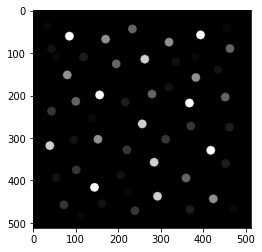

In [2]:
import cv2
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt

im = cv2.imread('res/dots.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(im,cmap='gray')
plt.show()

Por simplicidad, nuestro algoritmo consiste en una umbralización de la imagen. Aplicando distintos valores de umbral aparecen resaltadas distintas regiones de la imagen.

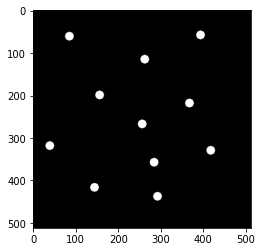

In [2]:
ret, thr = cv2.threshold(im, 127, 255, cv2.THRESH_BINARY)
plt.imshow(thr,cmap='gray')
plt.show()

Para poder validar el algoritmo necesitamos disponer del etiquetado manual (ground truth) realizado por un experto. Este etiquetado puede consistir, por ejemplo, en una imagen con las regiones etiquetadas en blanco o bien un fichero de texto con las coordenadas de las regiones.

En nuestro ejemplo disponemos de un fichero de texto con las coordenadas del centroide de cada región que han sido marcadas manualmente por un experto.

Por tanto, para realizar la comparación, necesitamos calcular los centroides de las regiones obtenidas mediante nuestro algoritmo. Utilizaremos la función `findContours` para obtener todos los contornos detectados en la imagen así como la función `moments` para calcular los momentos de cada contorno y, de esta forma, obtener el centroide de cada una de las regiones detectadas.


In [3]:
contours, _ = cv2.findContours(thr, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

centroids = []
for c in contours:
    M = cv2.moments(c)
    # Centroide de cada punto detectado
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    centroids.append([cx, cy])

dots_auto = np.array(centroids)


El siguiente paso es comparar la detección automática con los puntos que ha marcado de forma manual el experto. Para ello, leemos el fichero de texto con las coordenadas, las cuales se almacenan en un array.

Coordenadas de puntos detectados de forma manual:
[[419. 441.]
 [287. 430.]
 [137. 413.]
 [280. 352.]
 [413. 322.]
 [ 35. 314.]
 [150. 299.]
 [365. 213.]
 [ 98. 210.]
 [447. 201.]
 [153. 192.]
 [274. 195.]
 [ 78. 146.]
 [192. 122.]
 [258. 112.]
 [314.  72.]
 [166.  64.]
 [ 82.  54.]
 [391.  56.]
 [228.  40.]
 [266.  54.]
 [100.  24.]]


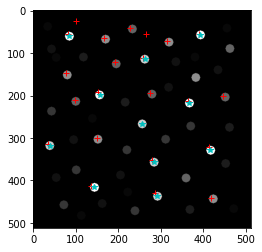

In [4]:
# Leer array con ground truth a partir de fichero de texto
dots_gt = np.genfromtxt('res/dots-gt.txt')
print ("Coordenadas de puntos detectados de forma manual:")
print (dots_gt)

plt.imshow(im, cmap='gray')
plt.plot(dots_gt[:,0], dots_gt[:,1], '+r')
plt.plot(dots_auto[:,0], dots_auto[:,1], '*c')
plt.show()

Por cada punto detectado de forma automática, debemos encontrar el punto manual más próximo y calcular la distancia entre ambos. Pueden suceder varios casos:
- La distancia entre el punto automático y el manual es inferior a un umbral prefijado: verdadero positivo
- La distancia entre el punto automático y el manual es superior a un umbral prefijado: falso positivo

Una vez procesados todos los puntos automáticos y encontradas sus correspondencias con los puntos manuales, los puntos manuales sin equivalencia con puntos automáticos son falsos negativos.

In [5]:
thr = 10 # umbral para considerar dos centroides en la misma región

# En este array almacenamos los indices de los centroides manuales
# que coinciden con los centroides automáticos
overlap_gt = [] 

for c in centroids:
    dx = dots_gt[:,0] - c[0]
    dy = dots_gt[:,1] - c[1]
    d = np.sqrt(dx * dx + dy * dy) # Distancia euclídea
    
    index = np.argmin(d) # Indice de la distancia mas pequeña
    # Si la distancia más pequeña es inferior al umbral y además
    # el punto manual no ha sido considerado antes, consideramos
    # que los dos centroides representan la misma region
    if np.min(d) < thr and index not in overlap_gt:
        overlap_gt.append(index)
        
print("VP:", len(overlap_gt))
print("FN:", dots_gt.shape[0] - len(overlap_gt))
print("FP:", dots_auto.shape[0] - len(overlap_gt))

VP: 10
FN: 12
FP: 1


### Ejercicios

1) A partir de los valores de VP, FP y FN, calcula las métricas de sensitividad y precisión.

In [6]:
# En primer lugar, recogemos en unos nuevos objetos los valores de VP, FP y FN que se han obtenido:
VP = len(overlap_gt)
FP = dots_auto.shape[0] - len(overlap_gt)
FN = dots_gt.shape[0] - len(overlap_gt)

# Métrica de sensitividad: 
#   sensitividad = VP / VP + FN

sensitividad = VP / (VP + FN)

# Métrica de precisión: 
#   precisión = VP / VP + FP

precisión = VP / (VP + FP)

# Muestra de los resultados correspondientes:
print('La métrica de sensitividad tiene un valor de {0:.2f}'.format(sensitividad))
print('La métrica de precisión presenta un valor de {0:.2f}'.format (precisión))


La métrica de sensitividad tiene un valor de 0.45
La métrica de precisión presenta un valor de 0.91


2) Aplicando distintos valores en la umbralización, calcula la sensitividad y el número de falsos positivos obtenidos. Dibuja la Free-Response ROC con los valores obtenidos. *Hint*: Usa `plt.plot(x, y)` para dibujar la curva, donde `x` e `y` son dos arrays con los valores de la función a dibujar en los ejes x e y, respectivamente.

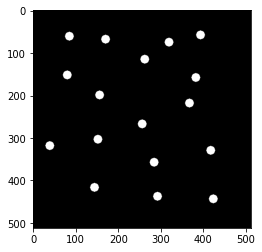

VP: 15
FN: 7
FP: 2
La métrica de sensitividad tiene un valor de 0.68
El número de falsos positivos es: 2


In [7]:
###################################################################
# 1) Umbral mínimo a 100:
ret_100, thr_100 = cv2.threshold(im, 100, 255, cv2.THRESH_BINARY)
plt.imshow(thr_100,cmap='gray')
plt.show()

# Se procede a la detección automática de los puntos:
contours, _ = cv2.findContours(thr_100, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

centroids = []
for c in contours:
    M = cv2.moments(c)
    # Centroide de cada punto detectado
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    centroids.append([cx, cy])

dots_auto = np.array(centroids)

###################################################################

thr = 10 # umbral para considerar dos centroides en la misma región

# En este array almacenamos los indices de los centroides manuales
# que coinciden con los centroides automáticos
overlap_gt = [] 

for c in centroids:
    dx = dots_gt[:,0] - c[0]
    dy = dots_gt[:,1] - c[1]
    d = np.sqrt(dx * dx + dy * dy) # Distancia euclídea
    
    index = np.argmin(d) # Indice de la distancia mas pequeña
    # Si la distancia más pequeña es inferior al umbral y además
    # el punto manual no ha sido considerado antes, consideramos
    # que los dos centroides representan la misma region
    if np.min(d) < thr and index not in overlap_gt:
        overlap_gt.append(index)
        
print("VP:", len(overlap_gt))
print("FN:", dots_gt.shape[0] - len(overlap_gt))
print("FP:", dots_auto.shape[0] - len(overlap_gt))

# En primer lugar, recogemos en unos nuevos objetos los valores de VP, FP y FN que se han obtenido:
VP = len(overlap_gt)
FP = dots_auto.shape[0] - len(overlap_gt)
FN = dots_gt.shape[0] - len(overlap_gt)

# Métrica de sensitividad: 
#   sensitividad = VP / VP + FN

sensitividad = VP / (VP + FN)

# Muestra de los resultados correspondientes:
print('La métrica de sensitividad tiene un valor de {0:.2f}'.format(sensitividad))
print('El número de falsos positivos es:', FP)


In [8]:
# Se generan unos arrays denominados x e y donde se recogen el número de falsos positivos y la fracción de verdaderos positivos respectivamente.
x = np.empty((0, 0), int)
y = np.empty((0, 0), int)

# Se añaden los valores alcanzados para esta imagen con umbral mínimo de 100:
x = np.append(x, FP)
print(x)

y = np.append(y, sensitividad)
print(y)

[2]
[0.68181818]


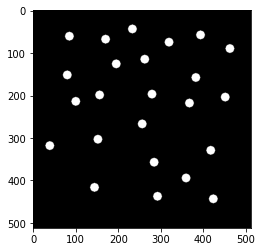

VP: 20
FN: 2
FP: 4
La métrica de sensitividad tiene un valor de 0.91
El número de falsos positivos es: 4


In [9]:
# Modificación del umbral mínimo a 50:
ret_50, thr_50 = cv2.threshold(im, 50, 255, cv2.THRESH_BINARY)
plt.imshow(thr_50,cmap='gray')
plt.show()

# Se procede a la detección automática de los puntos:
contours, _ = cv2.findContours(thr_50, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

centroids = []
for c in contours:
    M = cv2.moments(c)
    # Centroide de cada punto detectado
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    centroids.append([cx, cy])

dots_auto = np.array(centroids)

###################################################################

thr = 10 # umbral para considerar dos centroides en la misma región

# En este array almacenamos los indices de los centroides manuales
# que coinciden con los centroides automáticos
overlap_gt = [] 

for c in centroids:
    dx = dots_gt[:,0] - c[0]
    dy = dots_gt[:,1] - c[1]
    d = np.sqrt(dx * dx + dy * dy) # Distancia euclídea
    
    index = np.argmin(d) # Indice de la distancia mas pequeña
    # Si la distancia más pequeña es inferior al umbral y además
    # el punto manual no ha sido considerado antes, consideramos
    # que los dos centroides representan la misma region
    if np.min(d) < thr and index not in overlap_gt:
        overlap_gt.append(index)
        
print("VP:", len(overlap_gt))
print("FN:", dots_gt.shape[0] - len(overlap_gt))
print("FP:", dots_auto.shape[0] - len(overlap_gt))

# En primer lugar, recogemos en unos nuevos objetos los valores de VP, FP y FN que se han obtenido:
VP = len(overlap_gt)
FP = dots_auto.shape[0] - len(overlap_gt)
FN = dots_gt.shape[0] - len(overlap_gt)

# Métrica de sensitividad: 
#   sensitividad = VP / VP + FN

sensitividad = VP / (VP + FN)

# Muestra de los resultados correspondientes:
print('La métrica de sensitividad tiene un valor de {0:.2f}'.format(sensitividad))
print('El número de falsos positivos es:', FP)

In [10]:
# Se añaden los valores alcanzados para esta imagen con umbral mínimo de 50:
x = np.append(x, FP)
print(x)

y = np.append(y, sensitividad)
print(y)

[2 4]
[0.68181818 0.90909091]


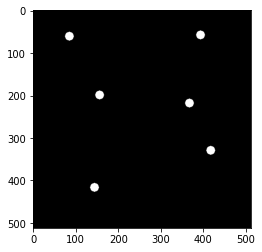

VP: 6
FN: 16
FP: 0
La métrica de sensitividad tiene un valor de 0.27
El número de falsos positivos es: 0


In [11]:
# Modificación del umbral mínimo a 200:
ret_200, thr_200 = cv2.threshold(im, 200, 255, cv2.THRESH_BINARY)
plt.imshow(thr_200,cmap='gray')
plt.show()

# Se procede a la detección automática de los puntos:
contours, _ = cv2.findContours(thr_200, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

centroids = []
for c in contours:
    M = cv2.moments(c)
    # Centroide de cada punto detectado
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    centroids.append([cx, cy])

dots_auto = np.array(centroids)

###################################################################

thr = 10 # umbral para considerar dos centroides en la misma región

# En este array almacenamos los indices de los centroides manuales
# que coinciden con los centroides automáticos
overlap_gt = [] 

for c in centroids:
    dx = dots_gt[:,0] - c[0]
    dy = dots_gt[:,1] - c[1]
    d = np.sqrt(dx * dx + dy * dy) # Distancia euclídea
    
    index = np.argmin(d) # Indice de la distancia mas pequeña
    # Si la distancia más pequeña es inferior al umbral y además
    # el punto manual no ha sido considerado antes, consideramos
    # que los dos centroides representan la misma region
    if np.min(d) < thr and index not in overlap_gt:
        overlap_gt.append(index)
        
print("VP:", len(overlap_gt))
print("FN:", dots_gt.shape[0] - len(overlap_gt))
print("FP:", dots_auto.shape[0] - len(overlap_gt))

# En primer lugar, recogemos en unos nuevos objetos los valores de VP, FP y FN que se han obtenido:
VP = len(overlap_gt)
FP = dots_auto.shape[0] - len(overlap_gt)
FN = dots_gt.shape[0] - len(overlap_gt)

# Métrica de sensitividad: 
#   sensitividad = VP / VP + FN

sensitividad = VP / (VP + FN)

# Muestra de los resultados correspondientes:
print('La métrica de sensitividad tiene un valor de {0:.2f}'.format(sensitividad))
print('El número de falsos positivos es:', FP)

In [12]:
# Se añaden los valores alcanzados para esta imagen con umbral mínimo de 200:
x = np.append(x, FP)
x = np.sort(x)
print(x)

y = np.append(y, sensitividad)
y = np.sort(y)
print(y)

[0 2 4]
[0.27272727 0.68181818 0.90909091]


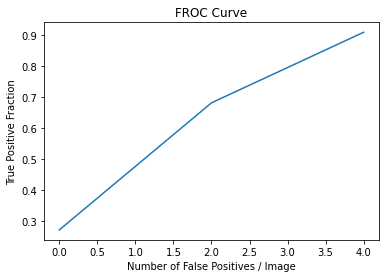

In [13]:
# Representación gráfica:
plt.plot(x,y)
plt.title("FROC Curve")
plt.xlabel("Number of False Positives / Image")
plt.ylabel("True Positive Fraction")
plt.show()

## Segmentación de regiones
En este problema vamos a evaluar la calidad de la segmentación realizada por un algoritmo en comparación con los resultados manuales etiquetados con un experto.

En este ejemplo, disponemos de una imagen en la que el experto ha marcado en color blanco las regiones de interés, en este caso, las regiones con células.

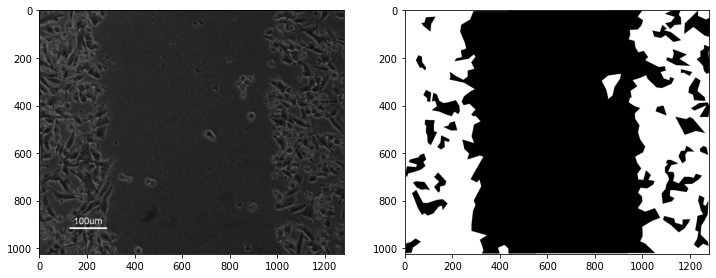

In [14]:
im = cv2.imread('res/melanoma.tif', cv2.IMREAD_GRAYSCALE)
gt = cv2.imread('res/melanoma-gt.png', cv2.IMREAD_GRAYSCALE)/255 # Solo etiquetas 0 y 1 en la imagen

plt.rcParams["figure.figsize"] = [12,12]
f, ax = plt.subplots(1,2)
ax[0].imshow(im,cmap='gray')
ax[1].imshow(gt, cmap='gray')
plt.show()

Nuestro algoritmo de segmentación consistirá simplemente en clusterizar los niveles de gris utilizando el algoritmo `kmeans`. [Para más detalles sobre este método, consultar el notebook sobre *Segmentacion*. ]

El objetivo de nuestro algoritmo es generar dos clústeres, uno para la zona con células y otro para la zona sin células.

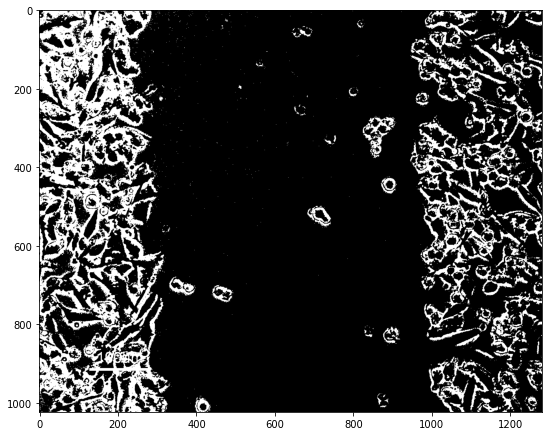

In [15]:
# Convertir la imagen a un vector unidimensional
Z = np.float32(im.reshape((-1,1)))

# Criterios de terminación del algoritmo
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

K = 2 # Número de clústeres
dist,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

# En este caso, no nos interesan los centros de clúster generados, sino la clasificación
# de los píxeles en una u otra categoría 
# Redimensionar el array plano a una imagen bidimensional
res = label.reshape((im.shape)) 

# Nos aseguramos que el valor 0 se asocie a las zonas sin células y el valor 1 a las 
# zonas con células. Como las zonas sin células son más oscuras, el centro de clúster 
# asociado a dichas zonas tendrá un valor más bajo. Si esto no es así, intercambiamos las
# etiquetas 0 y 1 de la imagen:
if center[0] > center[1]:
    res = 1 - res

plt.rcParams["figure.figsize"] = [9,9]
plt.imshow(res, cmap='gray')
plt.show()

El siguiente paso será comparar cada una de las regiones segmentadas de forma automática con el ground truth y obtener las regiones que se solapan en ambas imágenes:

Manual 0 vs Auto 0 | Píxeles solapados = 783069


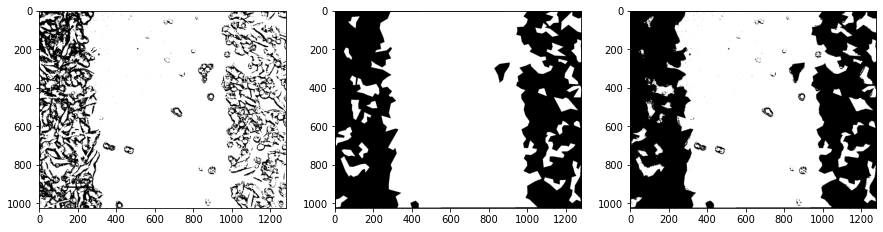

Manual 1 vs Auto 1 | Píxeles solapados = 201818


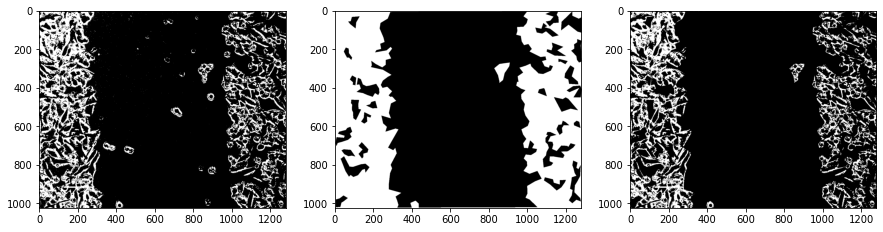

In [16]:
plt.rcParams["figure.figsize"] = [15,15]
for i in range(K):
    region_manual = (gt == i)
    region_auto = (res == i)
    overlap = region_auto * region_manual
    overlap_px = np.sum(overlap) 
    print ("Manual", i, "vs Auto", i, "| Píxeles solapados =", overlap_px)
    f, ax = plt.subplots(1,3)        
    ax[0].imshow(region_auto, cmap = 'gray')
    ax[1].imshow(region_manual, cmap = 'gray')
    ax[2].imshow(overlap, cmap = 'gray')
    plt.show()

### Ejercicios
1) Modifica el código anterior para calcular en cada región:
- Número de píxeles segmentados de forma automática que no aparecen en el ground truth
- Número de píxeles del ground truth que no aparecen en la segmentación automática

En cada caso, genera una imagen resultado para visualizar las zonas no segmentadas o segmentadas incorrectamente según el ground truth que disponemos.



Manual 0 vs Auto 0 | Píxeles segmentados de forma automática que no aparecen en el ground truth = 298084
Manual 0 vs Auto 0 | Píxeles del ground truth que no aparecen en la segmentación automática = 27749


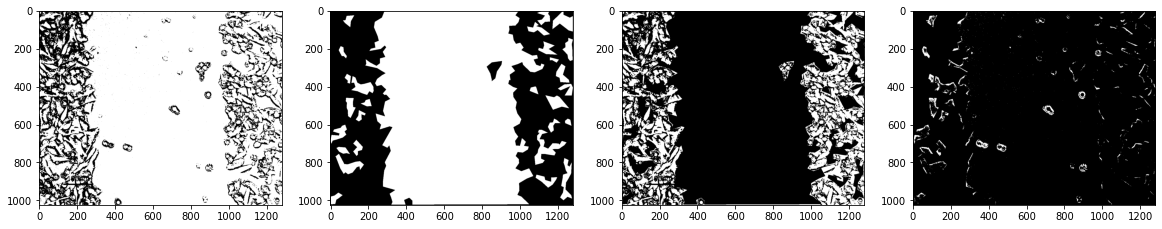

Manual 1 vs Auto 1 | Píxeles segmentados de forma automática que no aparecen en el ground truth = 27749
Manual 1 vs Auto 1 | Píxeles del ground truth que no aparecen en la segmentación automática = 298084


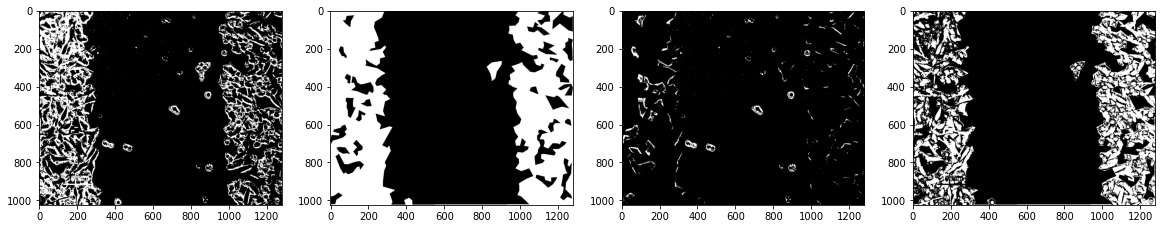

In [17]:
plt.rcParams["figure.figsize"] = [20,20]
for i in range(K):
    region_manual = (gt == i)
    region_auto = (res == i)
    overlap = region_auto * region_manual
    auto_no_gt = region_auto ^ overlap
    gt_no_auto = region_manual ^ overlap
    px_auto_no_gt = np.sum(auto_no_gt)
    px_gt_no_auto = np.sum(gt_no_auto)
    print ("Manual", i, "vs Auto", i, "| Píxeles segmentados de forma automática que no aparecen en el ground truth =", px_auto_no_gt)
    print ("Manual", i, "vs Auto", i, "| Píxeles del ground truth que no aparecen en la segmentación automática =", px_gt_no_auto)
    f, ax = plt.subplots(1,4)        
    ax[0].imshow(region_auto, cmap = 'gray')
    ax[1].imshow(region_manual, cmap = 'gray')
    ax[2].imshow(auto_no_gt, cmap = 'gray')
    ax[3].imshow(gt_no_auto, cmap = 'gray')
    plt.show()


2) Calcula la métrica de intersección sobre unión en las imágenes anteriores.

In [18]:
# Métrica IOU con las regiones segmentadas de forma automática y con el ground truth:

intersection = np.logical_and(region_manual, region_auto)
union = np.logical_or(region_manual, region_auto)

IOU = np.sum(intersection) / np.sum(union)

print('El resultado de la IOU es {0:.2f}'.format(IOU))


El resultado de la IOU es 0.38
